In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from tqdm import tqdm
import pandas as pd
import seaborn as sns
sns.set(style="white")
%matplotlib inline

np.random.seed(1234)

In [3]:
class RWMetropolis:
    def __init__(self, log_p, sigma):
        self.log_p = log_p
        self.sigma = sigma
        self.samples = []
    def sample(self, x0, nIter = 100):
        accepted = 0
        x = x0
        dim = x.shape[-1]
        logp = self.log_p(x)
        for i in tqdm(range(nIter)):
            x_prop = x + self.sigma * np.random.randn(dim)
            logp_prop = self.log_p(x_prop)
            alpha = min(1, np.exp(logp_prop - logp))
            if np.random.rand() < alpha:
                x = x_prop
                logp = logp_prop
                accepted += 1
            self.samples.append(x)
        print('Acceptance rate: %.2f%%' % (100.0*accepted/nIter))
        return np.asarray(self.samples)

In [5]:
class ODEfit:
    def __init__(self, t, X, x0, dxdt):      
        self.t = t
        self.x0 = x0
        self.X = X
        self.N = X.shape[0]
        self.dim = X.shape[1]
        self.dxdt = dxdt      
        self.sampler = RWMetropolis(self.log_posterior, 0.1)
        
    def log_prior(self, theta):
        sigma_sq = 1e2
        log_prior = -0.5*np.log(sigma_sq) - \
                     0.5*np.trace(np.matmul(theta, np.transpose(theta))/sigma_sq) - \
                     0.5*theta.shape[1]*np.log(2.0*np.pi)
        return log_prior
    
    def log_likelihood(self, theta):
        sigma_sq = 1e1
        mu = odeint(self.dxdt, self.x0, self.t, args= tuple(theta.flatten()))
        log_likelihood = -0.5*self.N*np.log(sigma_sq) - \
                          0.5*np.trace(np.matmul(self.X - mu, np.transpose(self.X - mu))/sigma_sq) - \
                          0.5*self.N*self.dim*np.log(2.0*np.pi)
        return log_likelihood
    
    
    def log_posterior(self, theta):
        log_posterior = self.log_likelihood(theta) + self.log_prior(theta)
        return log_posterior

In [6]:
# Define dynamics
def pendulum(x, t, b, c):
    phi, omega = x
    dxdt = [omega, -b*omega - c*np.sin(phi)]
    return dxdt

In [19]:
# True parameters
b = 0.25
c = 5.0
params = np.array([b,c])

n = 101
dim = 2
noise = 0.05

x0 = [np.pi - 0.1, 0.0]
t = np.linspace(0, 10, n)

# Generate time-series data
X = odeint(pendulum, x0, t, args = tuple(params))
X = X + noise*X.var(0)*np.random.randn(n, dim)

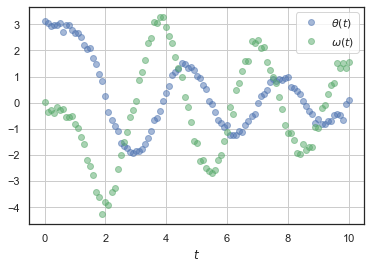

In [20]:
plt.figure()
plt.plot(t, X[:, 0], 'bo', label=r'$\theta(t)$', alpha = 0.5)
plt.plot(t, X[:, 1], 'go', label=r'$\omega(t)$', alpha = 0.5)
plt.legend(loc='best')
plt.xlabel(r'$t$')
plt.grid()

In [21]:
model = ODEfit(t, X, x0, pendulum)

In [22]:
# Sample
burn_in = 500
theta_init = np.array([[1.5,4.0]])
samples = model.sampler.sample(theta_init, nIter = 5000)[burn_in:,:]

100%|██████████| 5000/5000 [00:26<00:00, 186.03it/s]

Acceptance rate: 46.08%


Text(0, 0.5, 'c')

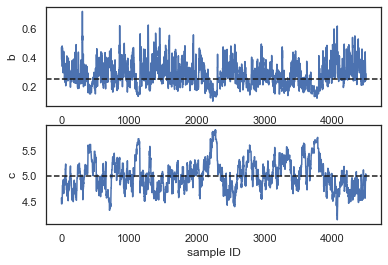

In [23]:
plt.figure()
plt.subplot(2,1,1)
plt.plot(samples[:,0,0])
plt.axhline(b, color='k', linestyle='--')
plt.xlabel('sample ID')
plt.ylabel('b')
plt.subplot(2,1,2)
plt.plot(samples[:,0,1])
plt.axhline(c, color='k', linestyle='--')
plt.xlabel('sample ID')
plt.ylabel('c')

In [24]:
# Posterior trajectories
X_pred = []
num_samples = 2000
for i in range(num_samples):
    sol = odeint(pendulum, x0, t, args = tuple(samples[-num_samples+i,:,:].flatten()))
    X_pred.append(sol)

Text(0, 0.5, 'c')

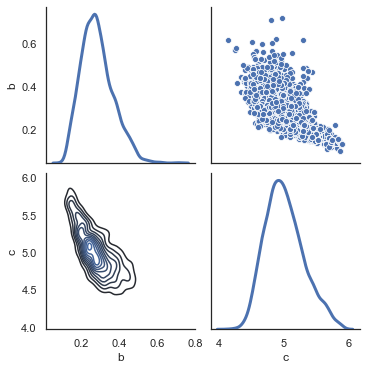

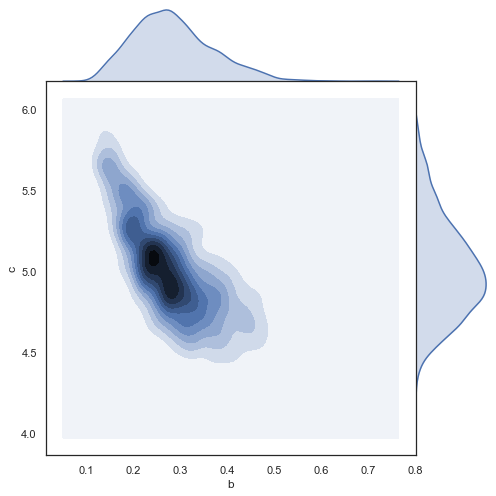

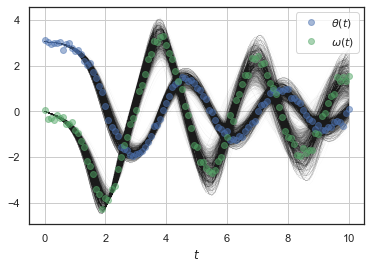

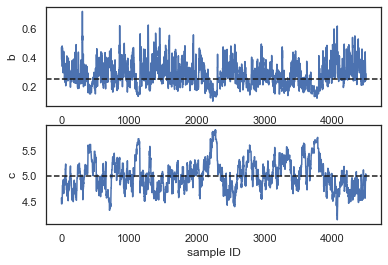

In [25]:
# Visualize
df = pd.DataFrame(samples[:,0,:], columns=['b', 'c'])

g = sns.PairGrid(df, diag_sharey=False)
g.map_lower(sns.kdeplot)
g.map_upper(sns.scatterplot)
g.map_diag(sns.kdeplot, lw=3)
# plt.savefig('./pairgrid.png', dpi = 300)

g = sns.jointplot(df['b'], df['c'], kind="kde", height=7, space=0)
# plt.savefig('./jointplot.png', dpi = 300)

plt.figure()
for i in range(num_samples):
    plt.plot(t, X_pred[i][:, 0], 'k', linewidth = 0.05, alpha = 0.2)
    plt.plot(t, X_pred[i][:, 1], 'k', linewidth = 0.05, alpha = 0.2)
plt.plot(t, X[:, 0], 'bo', label=r'$\theta(t)$', alpha = 0.5)
plt.plot(t, X[:, 1], 'go', label=r'$\omega(t)$', alpha = 0.5)
plt.legend(loc='best')
plt.xlabel(r'$t$')
plt.grid()
# plt.savefig('./time-series.png', dpi = 300)

plt.figure()
plt.subplot(2,1,1)
plt.plot(samples[:,0,0])
plt.axhline(b, color='k', linestyle='--')
plt.xlabel('sample ID')
plt.ylabel('b')
plt.subplot(2,1,2)
plt.plot(samples[:,0,1])
plt.axhline(c, color='k', linestyle='--')
plt.xlabel('sample ID')
plt.ylabel('c')